In [19]:
# Cell 1
import os, re, shutil, time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

pd.options.display.max_columns = 50
print("Libraries loaded")

# === EDIT THIS: set your working folder where Excel/CSV files are ===
workdir = r"C:\Users\hp\Desktop\AQI predictor"   # <-- CHANGE THIS to your folder
os.chdir(workdir)
print("Working dir:", os.getcwd())


Libraries loaded
Working dir: C:\Users\hp\Desktop\AQI predictor


In [20]:
# Cell 2
files = sorted([f for f in os.listdir('.') if f.lower().endswith(('.xlsx','.xls','.csv'))])
print("Spreadsheet files found:", len(files))
for f in files[:40]:
    print("-", f)
# backup previous outputs (safe)
ts = time.strftime("%Y%m%d_%H%M%S")
bakdir = f"backup_outputs_{ts}"
os.makedirs(bakdir, exist_ok=True)
for fname in ['combined_from_raw_pollutants.csv','combined_all.csv','combined_all_with_features.csv',
              'rf_aqi_model_v1.joblib','insample_comparison.csv','aqi_test_predictions.csv','AQI_monthly_analysis.xlsx']:
    if os.path.exists(fname):
        shutil.copy2(fname, os.path.join(bakdir, fname))
        print("Backed up", fname)
print("Backup folder (if any):", bakdir)


Spreadsheet files found: 12
- AQI_daily_city_level_bhopal_2022_bhopal_2022.xlsx
- AQI_daily_city_level_bhopal_2023_bhopal_2023.xlsx
- AQI_daily_city_level_bhopal_2024_bhopal_2024.xlsx
- AQI_daily_city_level_bhopal_2025_bhopal_2025.xlsx
- AQI_monthly_analysis.xlsx
- Bhopal T T Nagar  01-01-2021 000000 To 01-01-2022 235959.xlsx
- aqi_test_predictions.csv
- combined_all.csv
- combined_all_final.csv
- combined_all_with_features.csv
- combined_from_raw_pollutants.csv
- insample_comparison.csv
Backed up combined_from_raw_pollutants.csv
Backed up combined_all.csv
Backed up combined_all_with_features.csv
Backed up rf_aqi_model_v1.joblib
Backed up insample_comparison.csv
Backed up aqi_test_predictions.csv
Backed up AQI_monthly_analysis.xlsx
Backup folder (if any): backup_outputs_20251212_102803


In [ ]:
# Cell 3
def robust_read(path):
    path = str(path)
    if path.lower().endswith('.csv'):
        return pd.read_csv(path)
    # try openpyxl first
    try:
        return pd.read_excel(path, engine='openpyxl')
    except Exception:
        # try read_html (handles HTML disguised as xlsx)
        try:
            tables = pd.read_html(path)
            if tables:
                return tables[0]
        except Exception:
            # fallback: read bytes->string->save tmp html -> pandas.read_html
            with open(path, 'rb') as f:
                raw = f.read().decode('utf-8', errors='ignore')
            tmp = 'tmp_debug.html'
            with open(tmp, 'w', encoding='utf-8') as w:
                w.write(raw)
            tables = pd.read_html(tmp)
            if tables:
                return tables[0]
            raise 
            #"Ye function bahut smart hai. Dekho iska logic:
#Step 1: Agar CSV file hai → seedha pd.read_csv() use karo
#Step 2: Excel file hai → pehle normal pd.read_excel() try karo
#Step 3: Error aaye → kabhi-kabhi Excel files actually HTML format mein hoti hain, to pd.read_html() try karo
#Step 4: Phir bhi error → file ko bytes mein read karo, HTML mein convert karo, phir parse karo
#Iska faayda ye hai ki corrupt ya complex files bhi read ho jayengi."




In [22]:
# Cell 4
def sub_index_pm25(conc):
    # India NAQI 24-hr PM2.5 approximate breakpoints
    bins = [
        (0,30,0,50),
        (31,60,51,100),
        (61,90,101,200),
        (91,120,201,300),
        (121,250,301,400),
        (251,350,401,450),
        (351,500,451,500)
    ]
    for c_lo,c_hi,i_lo,i_hi in bins:
        if pd.notna(conc) and c_lo <= conc <= c_hi:
            return ((i_hi-i_lo)/(c_hi-c_lo))*(conc-c_lo) + i_lo
    return np.nan

def sub_index_pm10(conc):
    bins = [
        (0,50,0,50),
        (51,100,51,100),
        (101,250,101,200),
        (251,350,201,300),
        (351,430,301,400),
        (431,10000,401,500)
    ]
    for c_lo,c_hi,i_lo,i_hi in bins:
        if pd.notna(conc) and c_lo <= conc <= c_hi:
            return ((i_hi-i_lo)/(c_hi-c_lo))*(conc-c_lo) + i_lo
    return np.nan

def compute_overall_aqi_row(row):
    si = []
    for c in row.index:
        name = str(c).lower()
        if 'pm2' in name and pd.notna(row[c]):
            try:
                si.append(sub_index_pm25(float(row[c]))); break
            except: pass
    for c in row.index:
        name = str(c).lower()
        if 'pm10' in name and pd.notna(row[c]):
            try:
                si.append(sub_index_pm10(float(row[c]))); break
            except: pass
    return max(si) if si else np.nan

print("AQI helper functions ready")


AQI helper functions ready


In [23]:
# Cell 5
from pathlib import Path
all_files = sorted(Path('.').glob("*"))
candidates = []
for p in all_files:
    name = p.name.lower()
    if any(x in name for x in ['bhopal','t t nagar','tt nagar','paryavaran']) or any(y in name for y in ['2017','2018','2019','2020','2021','2022','2023','2024','2025']):
        if str(p).lower().endswith(('.xlsx','.xls','.csv')):
            candidates.append(str(p))
print("Attempting parse of candidate files:", len(candidates))

tidy_list = []
for f in candidates:
    print("\nProcessing:", Path(f).name)
    try:
        df = robust_read(f)
    except Exception as e:
        print("  Read failed:", e)
        continue
    print("  shape:", df.shape)
    cols = list(df.columns)
    # find date-like column
    date_col = None
    for c in cols:
        low = str(c).lower()
        if 'to (interval' in low or 'to (' in low or low.strip()=='to' or 'date' in low or 'from' in low or 'datetime' in low:
            date_col = c; break
    if date_col is None:
        date_col = cols[0]
        print("  using fallback date col:", date_col)
    # parse date
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    if df[date_col].isna().sum() > len(df)*0.8:
        # try 'From' column
        for alt in cols:
            if 'from' in str(alt).lower():
                df[alt] = pd.to_datetime(df[alt], errors='coerce')
                if df[alt].notna().sum() > 0:
                    date_col = alt
                    break
    df['date_parsed'] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=['date_parsed'])
    small = pd.DataFrame()
    small['date'] = df['date_parsed'].dt.normalize()
    # detect AQI or PMs
    aqi_col = None
    for c in df.columns:
        if 'aqi' in str(c).lower():
            aqi_col = c; break
    for c in df.columns:
        lc = str(c).lower()
        if ('pm2' in lc and ('2.5' in lc or '25' in lc or 'pm25' in lc)) or ('pm 2.5' in lc):
            small['PM2.5'] = pd.to_numeric(df[c], errors='coerce')
        if 'pm10' in lc:
            small['PM10'] = pd.to_numeric(df[c], errors='coerce')
        if aqi_col and c==aqi_col:
            small['AQI'] = pd.to_numeric(df[c], errors='coerce')
    small = small.groupby('date', as_index=False).mean()
    if 'AQI' not in small.columns or small['AQI'].isna().all():
        small['AQI'] = small.apply(compute_overall_aqi_row, axis=1)
    small = small.dropna(subset=['AQI'])
    print("  rows with AQI:", len(small))
    if len(small)>0:
        tidy_list.append(small[['date','AQI']])

if not tidy_list:
    raise ValueError("No tidy data created. Check file formats / working directory.")
combined = pd.concat(tidy_list, ignore_index=True)
combined = combined.drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
print("\nCombined:", combined.shape, "date range:", combined['date'].min(), "to", combined['date'].max())
combined.to_csv('combined_from_raw_pollutants.csv', index=False)
print("Saved combined_from_raw_pollutants.csv")
display(combined.head(8))


Attempting parse of candidate files: 5

Processing: AQI_daily_city_level_bhopal_2022_bhopal_2022.xlsx
  shape: (41, 13)
  using fallback date col: Day
  rows with AQI: 0

Processing: AQI_daily_city_level_bhopal_2023_bhopal_2023.xlsx
  shape: (41, 13)
  using fallback date col: Day
  rows with AQI: 0

Processing: AQI_daily_city_level_bhopal_2024_bhopal_2024.xlsx
  shape: (41, 13)
  using fallback date col: Day
  rows with AQI: 0

Processing: AQI_daily_city_level_bhopal_2025_bhopal_2025.xlsx
  shape: (41, 13)
  using fallback date col: Day
  rows with AQI: 0

Processing: Bhopal T T Nagar  01-01-2021 000000 To 01-01-2022 235959.xlsx
  shape: (369, 13)
  rows with AQI: 359

Combined: (359, 2) date range: 2021-01-01 00:00:00 to 2022-01-01 00:00:00
Saved combined_from_raw_pollutants.csv


,date,AQI
0,2021-01-01,303.386744
1,2021-01-02,315.803953
2,2021-01-03,313.540000
3,2021-01-04,331.398372
4,2021-01-05,243.843103
5,2021-01-06,289.110000
6,2021-01-07,254.596552
7,2021-01-08,294.811034


In [24]:
# Cell 6
combined['date'] = pd.to_datetime(combined['date'])
all_dates = pd.date_range(combined['date'].min(), combined['date'].max(), freq='D')
combined_full = pd.DataFrame({'date': all_dates}).merge(combined, on='date', how='left')
print("combined_full shape:", combined_full.shape, "Missing AQI days:", combined_full['AQI'].isna().sum())
combined_full.to_csv('combined_all.csv', index=False)
print("Saved combined_all.csv")


combined_full shape: (366, 2) Missing AQI days: 7
Saved combined_all.csv


In [25]:
# Cell 7
df = combined_full.copy()
df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df['Day_of_Week'] = df['date'].dt.dayofweek

# lags & rolling (shift to avoid leakage)
df['AQI_lag1'] = df['AQI'].shift(1)
df['AQI_lag7_mean'] = df['AQI'].rolling(window=7, min_periods=1).mean().shift(1)
df['AQI_roll7_std'] = df['AQI'].rolling(window=7, min_periods=1).std().shift(1).fillna(0)

# rows usable for supervised training (target present and lag1 present)
df_model = df.dropna(subset=['AQI','AQI_lag1']).reset_index(drop=True)
df_model.to_csv('combined_all_with_features.csv', index=False)
print("df_model shape (usable rows):", df_model.shape)
df_model.head()


df_model shape (usable rows): (351, 9)


,date,AQI,Year,Month,Day,Day_of_Week,AQI_lag1,AQI_lag7_mean,AQI_roll7_std
0,2021-01-02,315.803953,2021,1,2,5,303.386744,303.386744,0.000000
1,2021-01-03,313.540000,2021,1,3,6,315.803953,309.595349,8.780293
2,2021-01-04,331.398372,2021,1,4,0,313.540000,310.910233,6.613133
3,2021-01-05,243.843103,2021,1,5,1,331.398372,316.032267,11.580011
4,2021-01-06,289.110000,2021,1,6,2,243.843103,301.594435,33.805733


In [26]:
# Cell 8
features = ['Year','Month','Day','Day_of_Week','AQI_lag1','AQI_lag7_mean','AQI_roll7_std']
n = len(df_model)
test_size = int(0.2 * n)
train_df = df_model.iloc[:-test_size].copy()
test_df = df_model.iloc[-test_size:].copy()

X_train, y_train = train_df[features], train_df['AQI']
X_test,  y_test  = test_df[features], test_df['AQI']

model = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
print("Training on rows:", len(X_train))
model.fit(X_train, y_train)
joblib.dump(model, 'rf_aqi_model_v1.joblib')
print("Model trained and saved: rf_aqi_model_v1.joblib")

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# save test predictions
test_out = test_df[['date']].copy()
test_out['actual'] = y_test.values
test_out['predicted'] = np.round(y_pred,2)
test_out.to_csv('aqi_test_predictions.csv', index=False)
print("Saved aqi_test_predictions.csv")


Training on rows: 281
Model trained and saved: rf_aqi_model_v1.joblib
Test MAE: 50.114, RMSE: 65.159, R2: 0.216
Saved aqi_test_predictions.csv


In [27]:
# Cell 9
df_check = df.copy().sort_values('date').reset_index(drop=True)
df_check['AQI_lag1'] = df_check['AQI'].shift(1)
df_check['AQI_lag7_mean'] = df_check['AQI'].rolling(7, min_periods=1).mean().shift(1)
df_check['AQI_roll7_std'] = df_check['AQI'].rolling(7, min_periods=1).std().shift(1).fillna(0)
df_insample = df_check.dropna(subset=['AQI','AQI_lag1']).reset_index(drop=True)
X_insample = df_insample[features]
y_ins = df_insample['AQI'].values
y_ins_pred = model.predict(X_insample)
cmp = df_insample[['date']].copy()
cmp['actual'] = y_ins
cmp['predicted'] = np.round(y_ins_pred,2)
cmp.to_csv('insample_comparison.csv', index=False)
print("Saved insample_comparison.csv")


Saved insample_comparison.csv


In [28]:
# Cell 10
# Loads model if not in memory, uses combined_full for actual vs predict decision.

if 'model' not in globals():
    if os.path.exists('rf_aqi_model_v1.joblib'):
        model = joblib.load('rf_aqi_model_v1.joblib')
        print("Loaded model from rf_aqi_model_v1.joblib")
    else:
        print("Model not found in memory or disk. If you want predictions, run Cell 8 to train and save model.")

# features list must match training
_features = features

def _build_features_for_date(target_date):
    td = pd.to_datetime(target_date).normalize()
    # last available actual AQI
    recent = combined_full['AQI'].dropna()
    if recent.empty:
        raise RuntimeError("No AQI actuals available to compute lags.")
    last_aqi = float(recent.iloc[-1])
    lag7_mean = float(recent.tail(7).mean()) if len(recent)>=1 else last_aqi
    roll7_std = float(recent.tail(7).std()) if len(recent)>=2 else 0.0
    return pd.DataFrame([{
        'Year': td.year,
        'Month': td.month,
        'Day': td.day,
        'Day_of_Week': td.dayofweek,
        'AQI_lag1': last_aqi,
        'AQI_lag7_mean': lag7_mean,
        'AQI_roll7_std': roll7_std
    }])

def get_aqi_for_date(query_date, verbose=True):
    """
    If date exists in combined_full with non-null AQI -> return actual
    Else -> predict using model (requires model saved/loaded)
    """
    qd = pd.to_datetime(query_date).normalize()
    row = combined_full[combined_full['date'] == qd]
    if len(row)>0 and pd.notna(row.iloc[0].get('AQI', np.nan)):
        val = float(row.iloc[0]['AQI'])
        if verbose:
            print(f"[FROM DATA] {qd.date()} -> actual AQI = {val:.2f}")
        return val
    else:
        if 'model' not in globals():
            raise RuntimeError("Model not loaded. Run Cell 8 to train/load model.")
        X_new = _build_features_for_date(qd)
        X_new = X_new[_features]
        pred = float(model.predict(X_new)[0])
        if verbose:
            print(f"[PREDICT] {qd.date()} -> predicted AQI = {pred:.2f}")
        return pred

# Example usage:
# get_aqi_for_date("2025-03-20")  # returns actual if present
# get_aqi_for_date("2026-01-15")  # predicts (future)
print("Helper get_aqi_for_date() ready")


Helper get_aqi_for_date() ready


Saved AQI_monthly_analysis.xlsx


,avg,median,min,max,stddev,pred_next_year_midmonth
month,,,,,,
1,187.89,162.69,88.30,331.40,77.09,104.57
2,129.57,126.57,102.33,184.88,16.44,108.59
3,125.73,123.54,74.68,183.00,24.93,105.59
4,128.82,120.87,88.74,292.48,41.30,100.52
5,78.24,74.50,30.59,124.42,26.52,99.92
6,75.78,74.22,51.20,107.79,14.26,93.88
7,60.13,53.90,14.41,101.23,23.18,93.54
8,60.52,57.55,26.36,106.99,21.35,97.20
9,46.59,43.25,24.24,82.58,17.70,91.90


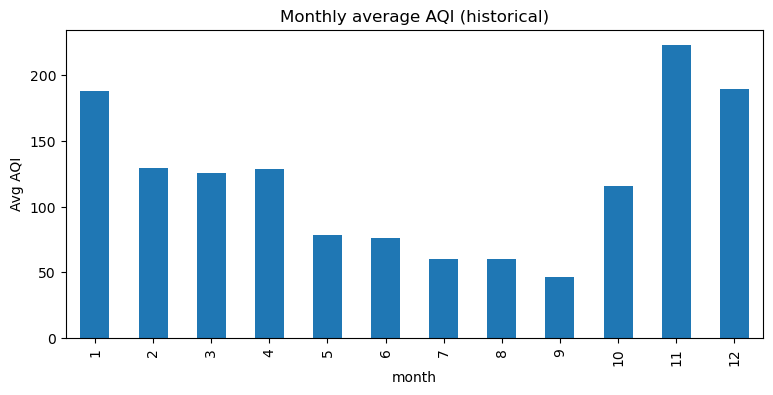

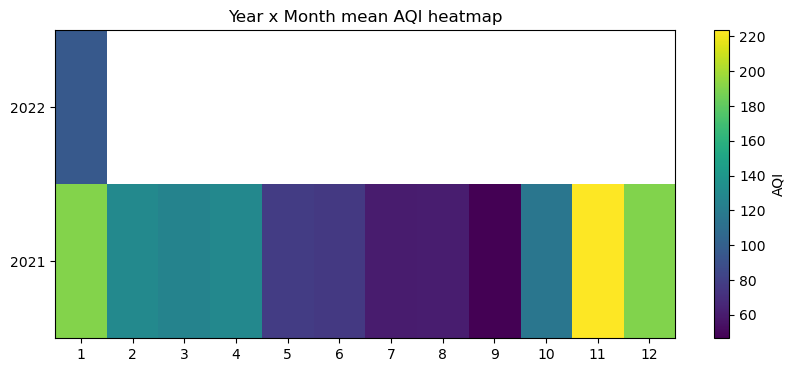

In [29]:
# Cell 11
df_stats = combined_full.copy()
df_stats['month'] = df_stats['date'].dt.month
monthly_stats = df_stats.groupby('month')['AQI'].agg(['mean','median','min','max','std']).round(2)
monthly_stats = monthly_stats.rename(columns={'mean':'avg','std':'stddev'})
# Predict representative mid-month next year values using trained model
last_row = df.sort_values('date').iloc[-1]
future_month_pred = {}
for m in range(1,13):
    target_date = pd.to_datetime(f"{last_row['date'].year+1}-{m}-15")
    X_new = _build_features_for_date(target_date)
    future_month_pred[m] = round(float(model.predict(X_new)[0]),2)

monthly_stats['pred_next_year_midmonth'] = monthly_stats.index.map(lambda m: future_month_pred[m])
monthly_stats.to_excel("AQI_monthly_analysis.xlsx")
print("Saved AQI_monthly_analysis.xlsx")
display(monthly_stats)

# plot monthly avg
plt.figure(figsize=(9,4))
monthly_stats['avg'].plot(kind='bar')
plt.title("Monthly average AQI (historical)")
plt.ylabel("Avg AQI")
plt.show()

# heatmap year x month
pivot = combined_full.copy()
pivot['year'] = pivot['date'].dt.year
pivot['month'] = pivot['date'].dt.month
pv = pivot.pivot_table(index='year', columns='month', values='AQI', aggfunc='mean')
plt.figure(figsize=(10,4))
plt.imshow(pv, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='AQI')
plt.yticks(range(len(pv.index)), pv.index)
plt.xticks(range(12), range(1,13))
plt.title("Year x Month mean AQI heatmap")
plt.show()


In [30]:
# Cell 12
# Save combined and model already saved earlier; save brief summary
combined_full.to_csv('combined_all_final.csv', index=False)
joblib.dump(model, 'rf_aqi_model_final.joblib')
print("Saved combined_all_final.csv and rf_aqi_model_final.joblib")

# Print summary
print("Data range:", combined_full['date'].min(), "->", combined_full['date'].max())
print("Total days:", len(combined_full))
print("Rows with AQI present:", combined_full['AQI'].count())
print("Model file:", os.path.exists('rf_aqi_model_final.joblib'))
print("Monthly analysis:", os.path.exists('AQI_monthly_analysis.xlsx'))


Saved combined_all_final.csv and rf_aqi_model_final.joblib
Data range: 2021-01-01 00:00:00 -> 2022-01-01 00:00:00
Total days: 366
Rows with AQI present: 359
Model file: True
Monthly analysis: True


In [31]:
#Cell 13
import pandas as pd, os

print("Files saved in working dir (filter):")
for f in sorted(os.listdir('.')):
    if any(x in f for x in ['combined_all_final','combined_all.csv','combined_from_raw_pollutants','combined_all_with_features','rf_aqi_model','AQI_monthly_analysis','insample_comparison','aqi_test_predictions']):
        print(" -", f)

# preview combined
print("\nCombined (first 6 rows):")
display(pd.read_csv('combined_all_final.csv', parse_dates=['date']).head(6))

# test set metrics & sample
if os.path.exists('aqi_test_predictions.csv'):
    test = pd.read_csv('aqi_test_predictions.csv', parse_dates=['date'])
    print("\nTest predictions sample:")
    display(test.tail(6))
else:
    print("\naqi_test_predictions.csv not found")

# insample compare sample
if os.path.exists('insample_comparison.csv'):
    cmp = pd.read_csv('insample_comparison.csv', parse_dates=['date'])
    print("\nIn-sample comparison (last 6):")
    display(cmp.tail(6))
else:
    print("insample_comparison.csv not found")

# monthly stats
if os.path.exists('AQI_monthly_analysis.xlsx'):
    ms = pd.read_excel('AQI_monthly_analysis.xlsx', index_col=0)
    print("\nMonthly stats preview:")
    display(ms)
else:
    print("AQI_monthly_analysis.xlsx not found")


Files saved in working dir (filter):
 - AQI_monthly_analysis.xlsx
 - aqi_test_predictions.csv
 - combined_all.csv
 - combined_all_final.csv
 - combined_all_with_features.csv
 - combined_from_raw_pollutants.csv
 - insample_comparison.csv
 - rf_aqi_model_final.joblib
 - rf_aqi_model_v1.joblib

Combined (first 6 rows):


,date,AQI
0,2021-01-01,303.386744
1,2021-01-02,315.803953
2,2021-01-03,313.540000
3,2021-01-04,331.398372
4,2021-01-05,243.843103
5,2021-01-06,289.110000



Test predictions sample:


,date,actual,predicted
64,2021-12-27,191.636207,211.42
65,2021-12-28,320.408605,164.55
66,2021-12-29,292.011724,198.12
67,2021-12-30,140.975517,196.36
68,2021-12-31,84.440000,141.60
69,2022-01-01,95.900000,106.90



In-sample comparison (last 6):


,date,actual,predicted
345,2021-12-27,191.636207,211.42
346,2021-12-28,320.408605,164.55
347,2021-12-29,292.011724,198.12
348,2021-12-30,140.975517,196.36
349,2021-12-31,84.440000,141.60
350,2022-01-01,95.900000,106.90



Monthly stats preview:


,avg,median,min,max,stddev,pred_next_year_midmonth
month,,,,,,
1,187.89,162.69,88.30,331.40,77.09,104.57
2,129.57,126.57,102.33,184.88,16.44,108.59
3,125.73,123.54,74.68,183.00,24.93,105.59
4,128.82,120.87,88.74,292.48,41.30,100.52
5,78.24,74.50,30.59,124.42,26.52,99.92
6,75.78,74.22,51.20,107.79,14.26,93.88
7,60.13,53.90,14.41,101.23,23.18,93.54
8,60.52,57.55,26.36,106.99,21.35,97.20
9,46.59,43.25,24.24,82.58,17.70,91.90


In [32]:
# Cell 14.
import os, pandas as pd, joblib

# 1) ensure combined_full is present in memory (or load from CSV)
if 'combined_full' not in globals():
    if os.path.exists('combined_all_final.csv'):
        combined_full = pd.read_csv('combined_all_final.csv', parse_dates=['date'])
        print("Loaded combined_full from combined_all_final.csv")
    elif os.path.exists('combined_all.csv'):
        combined_full = pd.read_csv('combined_all.csv', parse_dates=['date'])
        print("Loaded combined_full from combined_all.csv")
    else:
        raise FileNotFoundError("combined_full not in memory and no 'combined_all_final.csv' or 'combined_all.csv' found in working dir.")
# make sure date col is datetime and sorted
combined_full['date'] = pd.to_datetime(combined_full['date'])
combined_full = combined_full.sort_values('date').reset_index(drop=True)

# 2) ensure model is present in memory (or load joblib)
if 'model' not in globals():
    if os.path.exists('rf_aqi_model_final.joblib'):
        model = joblib.load('rf_aqi_model_final.joblib')
        print("Loaded model from rf_aqi_model_final.joblib")
    elif os.path.exists('rf_aqi_model_v1.joblib'):
        model = joblib.load('rf_aqi_model_v1.joblib')
        print("Loaded model from rf_aqi_model_v1.joblib")
    else:
        # model optional for actual-date queries but required for predictions
        model = None
        print("No saved model file found. Predictions will fail until you run training cell (Cell 8).")

# 3) define the helper function (robust, checks presence)
def get_aqi_for_date(date_str, verbose=True):
    """
    Returns: string with ACTUAL or PREDICT result
    Requires: combined_full (DataFrame) in memory
    If prediction needed, requires 'model' loaded in memory.
    """
    try:
        target = pd.to_datetime(date_str).normalize()
    except Exception:
        return "❌ Invalid date format. Use YYYY-MM-DD."
    # check actual
    try:
        row = combined_full[combined_full['date'] == target]
        if len(row) > 0 and pd.notna(row.iloc[0].get('AQI', None)):
            val = float(row.iloc[0]['AQI'])
            if verbose:
                print(f"[ACTUAL] {target.date()} -> AQI = {round(val,2)}")
            return val
    except Exception as e:
        return f"❌ Error reading combined_full: {e}"
    # need to predict
    if model is None:
        return "❌ No model loaded — cannot predict. Run model training cell (Cell 8) or load joblib."
    try:
        recent = combined_full['AQI'].dropna()
        if recent.empty:
            return "❌ No historical AQI values available to build lags for prediction."
        lag1 = float(recent.iloc[-1])
        lag7_mean = float(recent.tail(7).mean()) if len(recent) >= 1 else lag1
        lag7_std = float(recent.tail(7).std()) if len(recent) >= 2 else 0.0
        X_new = {
            'Year': target.year,
            'Month': target.month,
            'Day': target.day,
            'Day_of_Week': target.dayofweek,
            'AQI_lag1': lag1,
            'AQI_lag7_mean': lag7_mean,
            'AQI_roll7_std': lag7_std
        }
        import pandas as _pd
        Xdf = _pd.DataFrame([X_new])
        pred = float(model.predict(Xdf)[0])
        if verbose:
            print(f"[PREDICT] {target.date()} -> predicted AQI = {round(pred,2)}")
        return pred
    except Exception as e:
        return f"❌ Prediction error: {e}"

print("get_aqi_for_date() is defined and ready. Try e.g.: get_aqi_for_date('2022-11-15')")


get_aqi_for_date() is defined and ready. Try e.g.: get_aqi_for_date('2022-11-15')


In [33]:
print("\nFuture date (predicted):")
print(get_aqi_for_date("2025-12-11"))


Future date (predicted):
[PREDICT] 2025-12-11 -> predicted AQI = 96.09
96.08699449179548
